In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import pickle
import math
from collections import defaultdict
import numpy as np
import time
import bisect
import datetime
from tqdm import tqdm

from pandas import read_csv

In [2]:

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_json("/content/drive/MyDrive/Nov22small.json")
print(len(data))
dataorilen = len(data)

Mounted at /content/drive
70000


In [3]:
###2025.2.28

#data = pd.read_json('Nov22small.json')
#test_data = data.head(10)
#test_data = data[data['direction'] == -1].head(10)

def avgspeed(car_info):
    distance = math.sqrt(pow(car_info.y_position[-1] - car_info.y_position[0], 2) +
                         pow(car_info.x_position[-1] - car_info.x_position[0], 2))
    time = car_info.last_timestamp - car_info.first_timestamp
    return distance / time * 135 / 198  #  miles/h

def v_per_section(car_info):
    sections = len(car_info.y_position)
    sec_num = sections - 1
    velocity = []
    while sec_num > 0:
        distance = math.sqrt(pow(car_info.y_position[sec_num] - car_info.y_position[sec_num - 1], 2) +
                             pow(car_info.x_position[sec_num] - car_info.x_position[sec_num - 1], 2))
        time = car_info.timestamp[sec_num] - car_info.timestamp[sec_num - 1]
        velo = distance / time * 135 / 198  #  miles/h
        velocity.append(velo)
        sec_num -= 1
    return velocity


def calculate_flow(data, target_x, start_time, end_time):
    flow_count = 0

    for i in range(len(data)):
        x_positions = data.iloc[i].x_position
        timestamps = data.iloc[i].timestamp
        j = 1
        start_index = -1
        end_index = -1

        while j < len(timestamps) - 1:
            if (start_index == -1) and timestamps[j] >= start_time:
              start_index = j-1
            if timestamps[j] >= end_time:
              end_index = j
            if start_index != -1 and end_index != -1:
              break
            j = j+1

        if start_index == -1:
              continue
        if end_index == -1:
              end_index = len(timestamps)-1
        # have both start & end
        # print('start', start_index)
        # print('end', end_index)
        # print('len x_pos', len(x_positions))

        if x_positions[start_index] <= target_x <= x_positions[end_index] or \
           x_positions[start_index] >= target_x >= x_positions[end_index]:

            flow_count += 1


    # calc flow :veh/h
    time_window = end_time - start_time
    flow = flow_count / (time_window / 3600)

    return flow



# density
def interpolate_position(x1, x2, t1, t2, target_time):
    if t1 == t2:
        return x1
    return x1 + (x2 - x1) * (target_time - t1) / (t2 - t1)
def calculate_density(data, x_start, x_end, target_time):
    density_count = 0
    for i in range(len(data)):

        x_positions = data.iloc[i].x_position
        timestamps = data.iloc[i].timestamp

        for j in range(len(timestamps) - 1):
            if timestamps[j] <= target_time <= timestamps[j + 1]:
                x_interpolated = interpolate_position(
                    x_positions[j], x_positions[j + 1],
                    timestamps[j], timestamps[j + 1],
                    target_time
                )
                if x_start <= x_interpolated <= x_end:
                    density_count += 1
                break
    # density calc
    road_length = (x_end - x_start) / 63360  # in mile
    density = density_count / road_length  #  veh/mile

    return density

###average vehicles across time t - t+dt
def average_vehicles(data, t, dt):
    vehicle_count = 0
    for i in range(dt):
        current_time = t + i
        for j in range(len(data)):
            for k in data.iloc[j].timestamp:
              if 1> k - current_time > 0:
                vehicle_count += 1
                #print("j,i:",j,i)
                break

    return [vehicle_count, vehicle_count / dt]


#test
# a,b = average_vehicles(data.head(10), 1669118399,5)
# print(a,b)


#test



#test flow calc

# target_x = 321525
# start_time = float(1669110000)
# end_time =   float(1669130000)


#flow = calculate_flow(test_data, target_x, start_time, end_time)
#flow = calculate_flow(data, target_x, start_time, end_time)

#print(f"The flow in time frame [{start_time}, {end_time}] passing x = {target_x} is: {flow} veh/h")

# test density


# x_start = 321000
# x_end = 321530
# target_time = 1669120000

#density = calculate_density(test_data, x_start, x_end, target_time)
#density = calculate_density(data, x_start, x_end, target_time)
#print(f"Density at [{target_time}] seconds and within x-coord [{x_start}, {x_end}] is: {density} veh/mile")


## avg speed

vehicle_avg_dict = {f"{data.iloc[i]._id} mean_velocity": avgspeed(data.iloc[i]) for i in range(len(data))}
#vehicle_seg_dict = {f"{data.iloc[i]._id} segment_velocity": v_per_section(data.iloc[i]) for i in range(len(data))}
avg_speed = sum(vehicle_avg_dict.values()) / len(vehicle_avg_dict)

#print(f"Average Speed: {avg_speed} miles/h")





In [4]:
## data cleaning

### clean short line
data = data[data['timestamp'].apply(len) > 30]  ###time too short ( < 30 entries)

def at_least_one_min(timestamp):
    if abs(timestamp[0] - timestamp[-1]) < 5:   #### time too short , < 5 seconds
        return True
    return False
data = data[~data['timestamp'].apply(at_least_one_min)]

#rint(len(data))


### clean long horizontal line
def has_constant_x_position(x_pos, time):
    if len(x_pos) < time:
        return False
    for i in range(len(x_pos) - (time-1)):    ###### delete vehicle 30 seconds without moving
        if abs(x_pos[i] - x_pos[i+(time-1)]) <= 1:
            return True
    return False


data = data[~data['x_position'].apply(lambda x :has_constant_x_position(x, 30))]

#print(len(data))


data1 = data[data.direction == 1]
data2 = data[data.direction == -1]
print(len(data1))
print(len(data))
print(len(data2))


#data = data1
#data = data2

25971
50563
24592


In [5]:
########################### data cleaning
data = data[data['timestamp'].apply(len) > 30]

def at_least_one_min(timestamp,time):
    #print(timestamp)
    if abs(timestamp[0] - timestamp[-1]) < time:
        return True
    return False
#data = data[~data['timestamp'].apply(at_least_one_min)]
data = data[~data['timestamp'].apply(lambda x: at_least_one_min(x, 10))]
print(len(data))


28700


[41300, 41300, 41300, 41300, 41300, 41300]


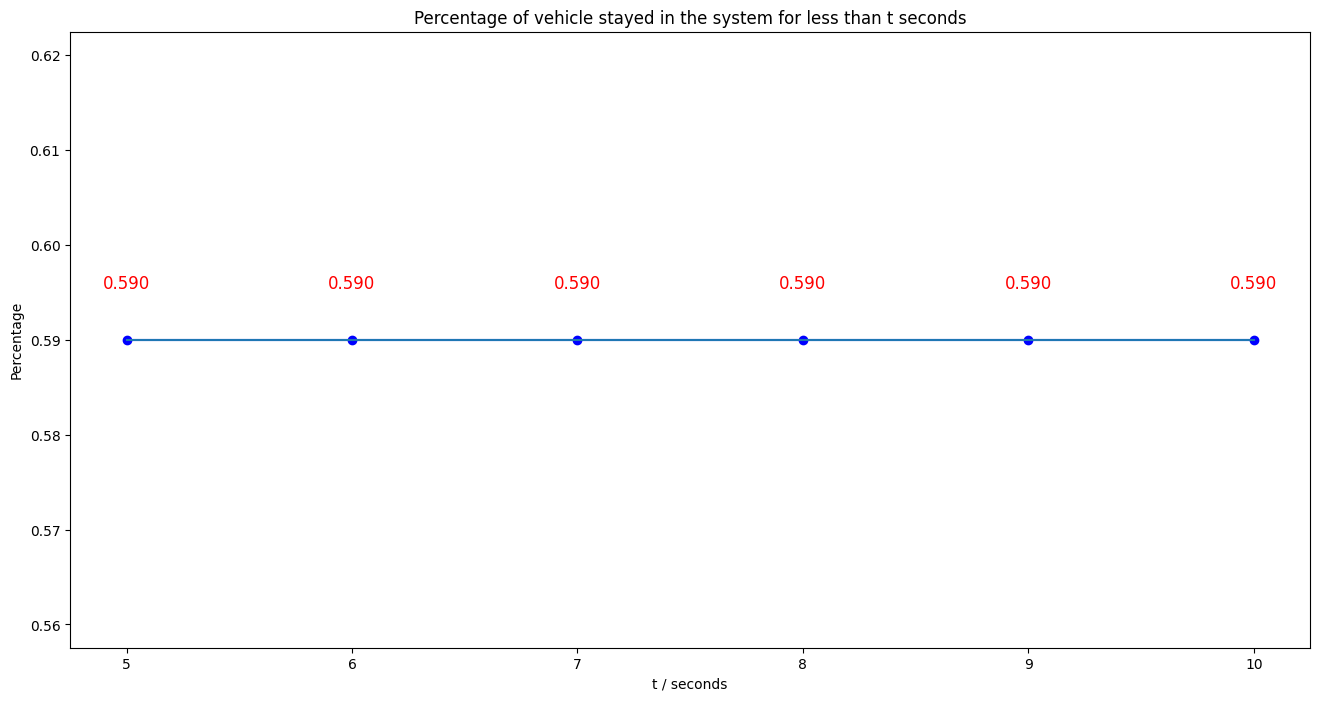

In [ ]:
#### percentage of vehicle stayed in the system for t seconds

import matplotlib.pyplot as plt

shortdata = []
time = [5,6,7,8,9,10]
for t in time:
  shortdata.append(dataorilen-len(data[~data['timestamp'].apply(lambda x: at_least_one_min(x, t))]))

print(shortdata)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

shortdata = np.array(shortdata)
time = np.array(time)


y_values = shortdata / dataorilen

ax.plot(time, y_values, marker='o', linestyle='-', color='b', label='Data Proportion')

for t_val, y_val in zip(time, y_values):
    ax.text(t_val, y_val + 0.005, f'{y_val:.3f}',
            ha='center', va='bottom', fontsize=12, color='red')

ax.plot(time,y_values)


ax.set_ylabel('Percentage')
ax.set_xlabel('t / seconds')
ax.set_title(r'Percentage of vehicle stayed in the system for less than t seconds')

plt.savefig('percentage stayed in.png')

fig.show()



In [ ]:

def has_constant_x_position(x_pos):
    if len(x_pos) < 30:
        return False
    for i in range(len(x_pos) - 29):
        if abs(x_pos[i] - x_pos[i+29]) <= 1:
            return True
    return False


data = data[~data['x_position'].apply(has_constant_x_position)]

print(len(data))

28700


In [6]:
data1 = data[data.direction == 1]
data2 = data[data.direction == -1]
print(len(data1))
print(len(data))
print(len(data2))

all_timestamps = data['timestamp'].explode().dropna().astype(float)

min_timestamp = all_timestamps.min()
max_timestamp = all_timestamps.max()



print(min_timestamp)
print(max_timestamp)
#print(data1.head(10))
data1.head(10).describe()
test10minx = 313610
test10maxx = 321010

13632
28700
15068
1669118399.9
1669120751.0


In [ ]:
######normalization prep, calc the mean and max of y for each x point across the entire highwawy for all time
ivl = 15
x_bins = np.arange(310283,  331555 ,ivl)
#print(x_bins)
mat = [[] for _ in range(len(data1))]
y_values = [[] for _ in range(len(x_bins))]

for index in range(len(data1)):
  x_arr = np.array(data1.iloc[index].x_position)
  y_arr = np.array(data1.iloc[index].y_position)

  for bin_index in range(len(x_bins)):
    mask = (x_arr > x_bins[bin_index]) & (x_arr < x_bins[bin_index]+10)
    first_index = np.argmax(mask) if np.any(mask) else None
    y_matched = y_arr[mask]
    #print(y_matched)
    #y_values[bin_index] = np.append(y_values[bin_index],y_matched)
    y_values[bin_index].extend(y_matched)
    mat.append([first_index])

## y_matched == in (corresponding index with x_bins ) x inteval (served as x pos points), the corresponding y positions

mat = np.array(mat, dtype=object)
# print(mat.shape)
# print(len(x_bins))

# print(len(y_values))

stats = []
for y_row in y_values:
    if len(y_row) > 0:
        row_mean = np.mean(y_row)
        row_max = np.max(y_row)
    else:
        row_mean = row_max = np.nan
    stats.append((row_mean, row_max))

#stats = at x pos = x( index same as in x_bin) the mean and max value of vehicles.

plt.figure(figsize=(12, 6))
#print(len(stats))

valid_points = []
for x, y_list in zip(x_bins, y_values):
    for y in y_list:
        if not np.isnan(y):
            valid_points.append((x, y))

valid_points = np.array(valid_points)
x_valid = valid_points[:, 0]
y_valid = valid_points[:, 1]


plt.figure(figsize=(8, 6))
plt.scatter(x_valid, y_valid, color='blue', label='Valid Points')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Non-NaN Coordinate Points')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
######### calc avg. velo. & vehicle ctr for each direction for 5 s of each segment of the road
import pickle

seg_len = 5280/4   # quarter  mile
start_x = 310283
#start_x = test10minx

num_segments = 17


timeseg = np.arange(1669118398, 1669120753, 5)
#timeseg = np.arange(1669118402, 1669118442,5)
print('time seg num :', len(timeseg))


#### data 1 = direction = 1 /// data2 = direcion = -1

#data_using = data.head(10)

data_using = data1

segs = np.arange(start_x, start_x + num_segments * seg_len, seg_len)
#segs = np.arange(start_x, test10maxx, seg_len)
print('x seg num:', len(segs))

t_values = [[[] for _ in range(len(timeseg))] for _ in range(len(segs))]

for car_id in range(len(data_using)):

    timestamps = data_using.iloc[car_id].timestamp
    x_pos = data_using.iloc[car_id].x_position

    time_array = np.array(timestamps)

    for seg_idx in range(len(segs)):
        seg_start = segs[seg_idx]
        if seg_idx < len(segs) - 1:
          seg_end = segs[seg_idx+1]
        else:
          seg_end = seg_start +seg_len

        in_seg_mask = (np.array(x_pos) >= seg_start) & (np.array(x_pos) < seg_end)
        seg_points = [(t, x) for t, x, m in zip(timestamps, x_pos, in_seg_mask) if m]

        if not seg_points:
            continue

        seg_times = [p[0] for p in seg_points]
        seg_pos = [p[1] for p in seg_points]
        #print(seg_pos)

        for t_idx, t_start in enumerate(timeseg):
          for ti , t  in enumerate(seg_times):
            end_index = -1

            if abs(t-t_start) < 1:
              start_index = ti
              if ti + 5 < len(seg_times):
                end_index = ti+5
              else:
                end_index = len(seg_times) - 1

            if end_index >-1 :
                dt = seg_times[end_index] - seg_times[start_index]
                dx = seg_pos[end_index] - seg_pos[start_index]
                # print(seg_pos[end_index])
                # print( seg_pos[start_index])
                # print(end_index)
                # print(start_index)
                # print(seg_times[end_index])
                # print(seg_times[start_index])
                if dt > 0:
                    speed = dx / dt
                    t_values[seg_idx][t_idx].append(speed)
print(t_values)
print(len(t_values))
print(len(t_values[0]))
print(len(t_values[0][1]))


counts = [[0 for _ in range(len(timeseg))] for _ in range(len(segs))]
averages = [[0.0 for _ in range(len(timeseg))] for _ in range(len(segs))]


for i in range(len(segs)):
    for j in range(len(timeseg)):
        current_list = t_values[i][j]

        num_elements = len(current_list)
        counts[i][j] = num_elements

        if num_elements > 0:
            avg = sum(current_list) / num_elements
        else:
            avg = 0.0
        averages[i][j] = avg

data_to_save = {
    "counts": counts,
    "averages": averages
}
with open("vehicle_ctr&Mean_velo.pkl", "wb") as f:
    pickle.dump(data_to_save, f)


print("Vehicle count:")
for row in counts:
    print(row)

print("\n Mean Velocity:")
for row in averages:
    print([f"{x:.2f}" for x in row])




In [ ]:
with open("vehicle_ctr&Mean_velo.pkl", "rb") as f:
    loaded_data = pickle.load(f)

counts= loaded_data["counts"]
averages = np.array(loaded_data["averages"]) * 0.681  ###feet/ sec to mph

print("Vehicle count:")
for row in counts:
    print(row)
    print(len(row))
print("\n Mean Velocity:")
for row in averages:
    print([f"{x:.2f}" for x in row])
    print(len(row))


In [ ]:
# ========================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)


ax1 = sns.heatmap(
    counts,
    ax=axes[0],
    cmap="YlGnBu",
    annot=False,
    cbar_kws={'label': 'Vehicle Count'},
    xticklabels=50,
    yticklabels=5
)


ax1.set_title("Vehicle Count Distribution")
ax1.set_xlabel("Time Window Index")
ax1.set_ylabel("Road Segment")
ax1.set_yticklabels([f"{segs[i]:.0f}-{segs[i+1]:.0f}" for i in range(len(segs)-1)][::5])
#ax1.set_xticklabels(np.arange(0, len(timeseg), 50))
ax1.set_xticklabels(np.arange(18398, 20753, 50*4.8))


ax2 = sns.heatmap(
    averages,
    ax=axes[1],
    cmap="RdYlGn",
    annot=False,
    cbar_kws={'label': 'Average Speed (mph)'},
    xticklabels=50,
    yticklabels=False    )

ax2.set_title("Average Speed Distribution")
ax2.set_xlabel("Time Window Index")
ax2.set_yticklabels([])
ax2.set_xticklabels(np.arange(18398, 20753, 50*4.8))

# ========================

fig.text(
    x=0.46, y=0.01,
    #s=f"Time Windows: {timeseg[0]} - {timeseg[-1]} (Unix Timestamp) \n +1.6691e9",
    s=f"(Unix Timestamp) \n +1.6691e9",

    ha='center',
    fontsize=12
)


plt.tight_layout()
plt.savefig('vehicle ctr & avg. velo.png')
plt.show()

0.09847247661323877


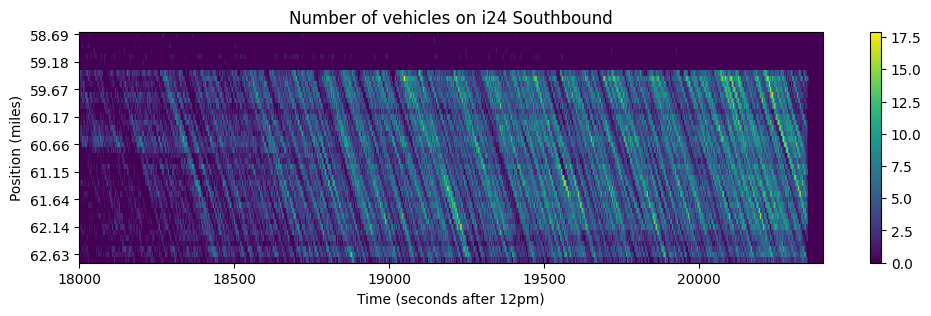

In [ ]:
#### density from qi
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()

#filtered_data = [entry for entry in data if entry['direction'] != -1]

# find min and max of x_position
# all_x_min = 100
# all_x_max = 0
# for entry in tqdm(data1):
#     print(entry)
#     min_x = min(entry.x_position)/5280
#     max_x = max(entry.x_position)/5280
#     if min_x < all_x_min:
#         all_x_min = min_x
#     if max_x > all_x_max:
#         all_x_max = max_x

# print("all_x_min: ", all_x_min)
# print("all_x_max: ", all_x_max)

all_x = data1.x_position.explode().dropna().astype(float)

all_x_min = all_x.min()/5280
all_x_max = all_x.max()/5280

# create even distributed bins for x_position
# num_bins = 84
num_bins = 42
x_bins = np.linspace(all_x_min, all_x_max+0.000001, num_bins+1)
bin_width = x_bins[1] - x_bins[0]
print(bin_width)

v_count_xt = np.zeros((6*3600*25, num_bins))

for i in range(len(data1)):
    #print(entry)
    timestamps = np.array(data1.iloc[i]['timestamp']).astype(float) - start_time
    timestamps = timestamps*25
    timestamps = timestamps.astype(int)

    positions = np.array(data1.iloc[i]['x_position'])/5280 - all_x_min
    positions = positions/bin_width
    positions = positions.astype(int)

    # print("timestamps: ", timestamps)
    # print("positions: ", positions)

    v_count_xt[timestamps, positions] += 1


v_count_xt1s = np.zeros((num_bins, 6*3600))

for i in range(6*3600):
    v_count_xt1s[:, i] = v_count_xt[i*25:(i+1)*25, :].mean(axis=0)
plt.figure(figsize=(12, 3))
plt.imshow(v_count_xt1s, aspect='auto', interpolation='nearest')
plt.xlim(5*3600, 20400)
#plt.xticks(np.arange(5*3600, 6*3600, 3600), np.arange(12, 13))
plt.yticks(np.arange(0, num_bins, 5), [f"{x:.2f}" for x in np.arange(all_x_min, all_x_max + bin_width, bin_width * 5)])
plt.title('Number of vehicles on i24 Southbound')
plt.xlabel('Time (seconds )')
plt.ylabel('Position (miles)')
plt.colorbar()
plt.show()

In [ ]:

def exit_at_62_3(x_pos):
  tar = 62.3
  ctr = 0
  if abs(x_pos[-1] / 5280 - tar) < 0.1:
      return True
  return False

data11 = data1[data1.x_position.apply(exit_at_62_3)]
print(len(data11))

In [ ]:
###### hard cleaning
#condition1 = data11['y_position'].apply(lambda lst: abs(lst[-1] - lst[0]) < 20)
condition2 = data1['y_position'].apply(lambda lst: (lst[-1] - lst[0]) < 40)
condition3 = data1['y_position'].apply(lambda lst: lst[-1] < -0.003*5280)
condition4 = data1['y_position'].apply(lambda lst: lst[0] < -0.002*5280)

condition5 = data1['y_position'].apply(lambda lst: lst[0] > -0.01*5280)
condition6 = data1['y_position'].apply(lambda lst: lst[-1] > -0.01*5280)

condition7 = data1['y_position'].apply(lambda lst: all(y <= -0.002*5280 for y in lst))
#filtered_data11 = data11[condition1 & condition2]
filtered_data11 = data1[condition7]

condition = data1['y_position'].apply(lambda lst: any(y > -0.001*5280 for y in lst))
invalid_rows = data1[condition]
print(invalid_rows.y_position)
print(data1.y_position[4644])
#filtered_data11 = data1[condition3 & condition4 & condition7]
#filtered_data11 = data1[condition3 & condition4 & condition5 & condition6]# & condition4]

#data = data[~data['timestamp'].apply(lambda x: at_least_one_min(x, 10))]




In [ ]:
### vehicle ctr for ramp
def vehicle_ctr(data,x_min,x_max,y_min,y_max):
  ctr = 0
  for i in range(len(data)):
    x_positions = data.iloc[i].x_position
    y_positions = data.iloc[i].y_position
    timestamps = data.iloc[i].timestamp
    for j in range(len(x_positions)):
      if x_min <= x_positions[j] <= x_max and y_min <= y_positions[j] <= y_max:
        ctr += 1
        print(i)
        print(j)
        print(len(timestamps))
        break

# OUT [59.7 59.9] ,  [ 60.0, 60.2] , [ 61.9 62.3] -0.012
#### or ?
xmin = 59.7 * 5280
xmax = 60.0 * 5280
#ymin =
ymax = -0.011 * 5280
#vehicle_ctr(data,xmin,xmax,ymin,ymax)
condition1 = data1['y_position'].apply(lambda lst: all(y <= ymax for y in lst))
#condition1 = data1['y_position'].apply(lambda lst: all(y >= ymin for y in lst))
condition3 = data1['x_position'].apply(lambda lst: all(y <= xmax for y in lst))
condition4 = data1['x_position'].apply(lambda lst: all(y >= xmin for y in lst))

filtered_data11 = data1[condition1  & condition3 & condition4]
print(len(filtered_data11))

In [ ]:
########### plot x vs. y
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)

for i in range(len(data1)):

    pos = np.array(data1.iloc[i].x_position)/5280
    y = np.array(data1.iloc[i].y_position)
    ax.plot(pos,y)

    ###############normalization
    # pos = np.array(filtered_data11.iloc[i].x_position)
    # y = np.array(filtered_data11.iloc[i].y_position)
    # adjusted_y = []
    # for x, y in zip(pos, y):
    #     index = int(np.floor((x - 313470) / 15))
    #     adjusted_y.append(-y / stats[index][0])
    # ax.plot(pos/5280, adjusted_y)

    # #############
ax.set_xlim(61.2, 62.1)
ax.set_ylim(-0.02*5280, -0.005*5280)

plt.xlabel('X Position (MM)')
plt.ylabel('Y Position')
plt.title('X vs. Y Pos at Exit 62.3 MM')
plt.legend()
plt.savefig('exit62.3.png')
fig.show()

In [ ]:
#### test part
data11.describe()
#data11.columns
ystart = []
yend = []
ydist = []
v = range(len(data11))
for i in v:
  ystart.append(data11.iloc[i].y_position[0])
  yend.append(data11.iloc[i].y_position[-1])
  ydist.append(data11.iloc[i].y_position[-1] - data11.iloc[i].y_position[0])
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
ax.scatter(v,ystart)
ax.scatter(v,yend)
ax.plot(v,ydist)
fig.show

# for i in range(20):
#   print(data11.iloc[i].y_position[0])
#   print(data11.iloc[i].y_position[-1])

In [ ]:
########################segment
def segment_list(lst, segment_size):
    res = []
    for i in range(0, len(lst)+1, segment_size):
      if i+segment_size <= len(lst):
        res.append([lst[i],lst[i + segment_size]])
      else: break
    return res

time_list = np.arange(data.timestamp.explode().min(), data.timestamp.explode().max() + 1, step=1).tolist()
time_targets = np.arange(data.timestamp.explode().min(), data.timestamp.explode().max() + 1, step=100).tolist()
### density cal per 100 seconds
print(len(time_list))

segmented_time_list = segment_list(time_list, 100)
#flow cal each for 200s interval

#print(segmented_time_list[0])
space_list = np.arange(data["x_position"].explode().min(), data["x_position"].explode().max() + 1, step=1).tolist()
space_targets = np.arange(data["x_position"].explode().min(), data["x_position"].explode().max() + 1, step=500).tolist()
# flow cal per 1000 inches

segmented_space_list = segment_list(space_list, 1000)
# density cal each for 2000 inches interval

In [ ]:
density_list = []
flow_list = []
print(len(time_targets),len(space_targets),len(segmented_time_list),len(segmented_space_list))
for i in range(len(time_targets)):
   for item in segmented_space_list:
    density_list.append(calculate_density(data[data.direction == 1], item[0], item[1], time_targets[i]))

# start_time = time.time()
#
# #density_list.append(calculate_density(data, segmented_space_list[0][0], segmented_space_list[0][1], time_targets[0]))

with open("density_3.13_d=1.json", "w") as file:
    json.dump(density_list, file)

# end_time = time.time()

# elapsed_time = end_time - start_time



In [ ]:
for i in range(len(space_targets)):
  for item in segmented_time_list:
    flow_list.append( calculate_flow(data, space_targets[i], item[0], item[1]))


with open("flow_3.2.json", "w") as file:
    json.dump(flow_list, file)

In [ ]:
###reload data
with open('density_3.13_d=1.json', 'r', encoding='utf-8') as file:

    density_list =  json.load(file)
with open('flow_3.14.json', 'r', encoding='utf-8') as file:

    flow_list =  json.load(file)
###

In [ ]:
## data process

#print(len(density_list))#,len(flow_list))
#print(len(time_targets),len(space_targets))

d_l = list([] for i in range(int(len(density_list)/len(time_targets))))

f_l = list([] for i in range(int(len(flow_list)/len(space_targets))))

for i in range(len(density_list)):
  d_l[math.floor(i/(len(time_targets)))].append(density_list[i])

for i in range(len(flow_list)):
  f_l[math.floor(i/len(space_targets))].append(flow_list[i])


In [ ]:
################  x pos vs time
# with open('Nov22small.json', 'r') as file:
#     data = json.load(file)

#timestamps = [datetime.datetime.fromtimestamp(t).time().strftime("%H:%M:%S.%f")[:-3] for t in data.timestamp[0]]
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)

for i in range(min(70000, len(data))):
    #i = j * 10+3
    if data.iloc[i].direction == 1:
        continue
    pos = np.array(data.iloc[i].x_position)/5280
    timestamps = np.array(data.iloc[i].timestamp) #- start_time
    ax.plot(timestamps, pos)

plt.ylabel('X Position (MM)')
plt.xlabel('Time')
plt.title('x_pos vs time')
plt.legend()
plt.savefig('x_pos vs time.png')
fig.show()

In [ ]:
## graphing
#print(segmented_time_list )
from matplotlib.ticker import FuncFormatter

start_time = datetime.datetime(2022, 11, 22, 7, 0)

tstamps = [datetime.datetime.fromtimestamp(t[0]).time().strftime("%H:%M:%S.%f")[:-3] for t in segmented_time_list ]
base_time = 1.6691e9

x = range(len(d_l))
t = np.array(time_targets)
T,X = np.meshgrid(t,x)

space = space_targets
print(space)
time = range(len(f_l))
sp,ti = np.meshgrid(space, time)
#print(time)


##draw

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

#：rho(x, t) density
c = ax1.contourf( T,X, d_l, levels=50, cmap='viridis')
ax1.set_ylabel('x / miles')
ax1.set_xlabel('t / seconds')
ax1.set_title(r'$\hat{\rho}(x,t)$')

yticks = x
yticklabels =  [np.around(i / 5280,2) for i,y in segmented_space_list ]

ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)
fig.colorbar(c, ax=ax1,label='Intensity')



# ：u(x, t) : flow
c = ax2.contourf(ti, sp, f_l, levels=50, cmap='plasma')
ax2.set_ylabel('x / miles')
ax2.set_xlabel('t ')
ax2.set_title(r'$\hat{u}(x,t)$')




xticks = time
xticklabels = [int(float(x)) if isinstance(x, str) else int(x) for x in np.array((time_targets[0:-1]))- base_time]

def time_formatter(x, pos):
    offset = x
    if offset == 20599:
        return f"{offset}\n+{base_time:.4e}"
    return str(offset)

ax2.xaxis.set_major_formatter(FuncFormatter(time_formatter))

ax2.set_xticks(xticks)

ax2.set_xticklabels(xticklabels)

ax2.set_yticks(space)
yticklabels2 = [np.around(i / 5280,2) for i in space_targets ]
ax2.set_yticklabels(yticklabels2)
fig.colorbar(c, ax=ax2,label='Intensity')

#plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('3.13_d_100s_1000in_f_100s_500in.png')
plt.show()

In [ ]:
def load_ramp_data():
  ramp_data = read_csv(ramp_and_landmark_layer.csv)
def create_ramp_list(ramp_data):
  x_pos_eb_ramps = []

#Direction "EB"=east bound, "WB"= west bound
#Boarding "on" = "off"
#RELIC - not as efficient.
def ramp_loaded_vehicles(data, ramp_loc, start_time, end_time, direction = "EB", boarding = "on", buffer = 50):
  change_count = 0
  for i in range(len(data)):
    x_positions = data.iloc[i].x_position
    timestamps = data.iloc[i].timestamp
    y_positions = data.iloc[i].y_position
    j = 0
    start_index = -1
    end_index = -1
    while j < len(timestamps) - 1:
      if (start_index == -1) and timestamps[j] >= start_time:
        start_index = j-1
      if timestamps[j] >= end_time:
        end_index = j
      if start_index != -1 and end_index != -1:
        break
      if start_index == -1:
        continue
      if end_index == -1:
        end_index = len(timestamps) - 1


    match direction:
      case "EB":
        match boarding:
          case "on":
            if x_positions[start_index] <= ramp_loc + buffer <= x_positions[end_index]:
              if x_positions[start_index] >= ramp_loc - buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc + buffer, lo=start_index, hi=end_index)
                if(-36<=y_positions[ramp_buffer_index] <= -24):
                  change_count+=1
           # in correct lane
          case "off":
            if x_positions[start_index] <= ramp_loc - buffer <= x_positions[end_index]:
              if x_positions[end_index] <= ramp_loc + buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc - buffer, lo=start_index, hi=end_index)
                if(-36<=y_positions[ramp_buffer_index] <= -24):
                  change_count+=1
           # in correct lane
      case "WB":
        match boarding:
          case "on":
            if x_positions[start_index] <= ramp_loc - buffer <= x_positions[end_index]:
              if x_positions[start_index] <= ramp_loc + buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc - buffer, lo=start_index, hi=end_index)
                if(36 >= y_positions[ramp_buffer_index] >= 24):
                  change_count+=1
          case "off":
            if x_positions[start_index] <= ramp_loc + buffer <= x_positions[end_index]:
              if x_positions[end_index] >= ramp_loc - buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc + buffer, lo=start_index, hi=end_index)
                if(36 >= y_positions[ramp_buffer_index] >= 24):
                  change_count+=1
  return change_count


In [ ]:
#Just look at how far away either the starting or ending points are from it in order to do this! EASY
def ramp_loaded_vehicles_alt_count(data,ramp_loc,direction="EB",buffer=10,lane_size = 36):
  ramp_before = 0
  ramp_after = 0
  ramp_middle = 0
  for i in range(len(data)):
    x_positions = data.iloc[i].x_position
    timestamps = data.iloc[i].timestamp
    y_positions = data.iloc[i].y_position
    j = 0
    start_index = 0
    end_index = len(timestamps) - 1
    '''
    while j < len(timestamps) - 1:
      if (start_index == -1) and timestamps[j] >= start_time:
        start_index = j-1
      if timestamps[j] >= end_time:
        end_index = j
      if start_index != -1 and end_index != -1:
        break
      if start_index == -1:
        continue
      if end_index == -1:
        end_index = len(timestamps) - 1
    '''
    match direction:
      case "EB":
        if x_positions[start_index] <= ramp_loc - buffer and x_positions[end_index] >= ramp_loc - buffer and y_positions[start_index] < 0:
          ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc - buffer, lo=start_index, hi=end_index)
          if y_positions[ramp_buffer_index] >= -1 * lane_size:
            ramp_before+=1
        if x_positions[end_index] >= ramp_loc + buffer and x_positions[start_index] <= ramp_loc + buffer and y_positions[start_index] < 0:
          ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc+buffer, lo=start_index, hi=end_index)
          if y_positions[ramp_buffer_index] >= -1 * lane_size:
            ramp_after+=1
        if x_positions[start_index] <= ramp_loc and x_positions[end_index] >= ramp_loc and y_positions[start_index] < 0:
          ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc, lo=start_index, hi=end_index)
          if y_positions[ramp_buffer_index] >= -1 * lane_size:
            ramp_middle+=1

      case "WB":
        if x_positions[start_index] >= ramp_loc + buffer and x_positions[end_index] <= ramp_loc + buffer and y_positions[start_index] > 0:
          ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc+buffer, lo=start_index, hi=end_index)
          if y_positions[ramp_buffer_index] <= lane_size:
            ramp_before+=1
        if x_positions[end_index] <= ramp_loc - buffer and x_positions[start_index] >= ramp_loc - buffer and y_positions[start_index] > 0:
          ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc-buffer, lo=start_index, hi=end_index)
          if y_positions[ramp_buffer_index] <= lane_size:
            ramp_after+=1
        if x_positions[end_index] <= ramp_loc and x_positions[start_index] >= ramp_loc and y_positions[start_index] > 0:
          ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc, lo=start_index, hi=end_index)
          if y_positions[ramp_buffer_index] <= lane_size:
            ramp_middle+=1
  return ramp_before, ramp_after, ramp_middle


In [ ]:
print(segmented_time_list)
result = ramp_loaded_vehicles(data1, 60*5280, segmented_time_list[0][0], segmented_time_list[0][1])

In [ ]:
all_data = []

for i in range(32,50,3):
  for j in range(18,30,2):
    for k in range(0,3):
      mile_marker = (62.46+k*0.01)*5280
      ramp_before,ramp_after,ramp_middle = ramp_loaded_vehicles_alt_count(data1, mile_marker, direction="EB", buffer=j*.01*5280, lane_size=i)
      all_data.append({
              "Mile marker": mile_marker,
              "buffer": j*.01*5280,
              "Ramp before": ramp_before,
              "Ramp after": ramp_after,
              "Ramp middle": ramp_middle,
              "lane size": i,
              "direction": "EB"
          })

In [ ]:
from google.colab import files

all_data = pd.DataFrame(all_data)

# Save to Excel
all_data.to_excel("ramp_data.xlsx", index=False)

# Download the file
files.download("ramp_data.xlsx")

In [ ]:
#print(result1)

In [ ]:
print(len(segmented_time_list))

In [ ]:
print(segmented_time_list[0][1])

In [ ]:
print(segmented_time_list[4][0])

In [ ]:

data_onboard = []
data_offboard = []
data_middle = []
data_exit = []
data_enter = []
for i in range(500):
  onr, offr, offm = ramp_loaded_vehicles_alt_count(data1, (i*0.01 + 58)*5280, buffer=300)
  data_onboard.append(onr)
  data_offboard.append(offr)
  data_middle.append(offm)
  data_exit.append(offm - onr)
  data_enter.append(offr - offm)

In [ ]:
for i in range(100):
  onr, offr, offm = ramp_loaded_vehicles_alt_count(data1, (i*0.01 + 63)*5280, buffer=300)
  data_onboard.append(onr)
  data_offboard.append(offr)
  data_middle.append(offm)
  data_exit.append(offm - onr)
  data_enter.append(offr - offm)

In [ ]:
########### this one only
def largest_adjacent_differences_indices(arr, n=8):
    arr = np.array(arr)
    # Calculate absolute differences between adjacent elements
    diffs = np.abs(np.diff(arr))

    # Get indices of the n largest differences
    largest_indices = np.argpartition(-diffs, n)[:n]

    # Sort them by actual value (optional)
    largest_indices = largest_indices[np.argsort(-diffs[largest_indices])]

    return largest_indices.tolist()
print(np.sort(largest_adjacent_differences_indices(data_exit,10)))
print(np.sort(largest_adjacent_differences_indices(data_enter,10)))
#252-258, 280-288, 325-331, 367-___, 478-484 are the most likely exits so i*.01+58 MM for each of these.
#247-252, 274-280, 319-325, 361-367, 473-478 are the most likely entrances so i*.01+58 MM for each of these.
data_exit = np.array(data_exit)
data_enter = np.array(data_enter)
MM_exits = np.array([255,284,328,371,482])
MM_enter = np.array([250,277,322,364,476])
print(data_exit[MM_exits])
# Eliminates maxes only includes mins
def transformExitMM(index_vals):
  mask = data_exit[index_vals] < 0
  index_vals = index_vals[mask]
  return index_vals * .01 + 58
#Eliminates min
def transformEnterMM(index_vals):
  mask = data_enter[index_vals] > 0
  index_vals = index_vals[mask]
  return index_vals * .01 + 58
MM_exits = transformExitMM(np.array(MM_exits))
MM_enter = transformExitMM(np.array(MM_enter))
print(MM_exits)
print(MM_enter)

In [ ]:
x_axis = [i * 0.01 + 58 for i in range(len(data_onboard))]
#plt.plot(x_axis, data_onboard, label='on ramp', color='blue')
#plt.plot(x_axis, data_offboard, label='off ramp', color='red')
#plt.plot(x_axis, data_middle, label='middle', color='orange')
plt.plot(x_axis, data_enter, label='enter', color='green')
#plt.plot(x_axis, data_exit, label = 'exit', color='red')
#plt.plot(x_axis, data_change, label = 'enter', color = 'orange')
plt.legend()
plt.title('Plot of on and off traffic')
plt.xlabel('MM')
plt.ylabel('Value')
plt.show()

In [ ]:
#USING 62.82 (62.77) as when the data actually leaves the frame for the exit, and then 62.76 (62.81) as when the data actually enters the frame for the entrance. Parenthesis denotes what this implies as the location

In [ ]:
result1 = ramp_loaded_vehicles_alt_count(data2, 60.05*5280,direction = "WB", buffer=300)

In [ ]:
print(result1)

In [ ]:
#Find all for which ramp_after and ramp_before are greater than middle, and then sort by how much
cars_lost = np.subtract(np.array(data_onboard), np.array(data_middle))
cars_gained = np.subtract(np.array(data_offboard), np.array(data_middle))
ramp_indices = []
for i in range(len(cars_lost)):
  if cars_lost[i] > 0 and cars_gained[i] > 0:
    if cars_lost[i] + cars_gained[i] > 1000:
      ramp_indices.append(i)

In [ ]:
print(ramp_indices)

In [ ]:
#208, 251, 285, 366 are centers of ramps
#For 208
ramps = np.array([208,251,285,366])
data_onboard = np.array(data_onboard)
data_offboard = np.array(data_offboard)
data_middle = np.array(data_middle)
before = data_onboard[ramps]
middle = data_middle[ramps]
after = data_offboard[ramps]
print(before, middle, after)
#1089 cars go to 476 which goes to 978
percent_exit = 100 * (before - middle)/ before
percent_enter = 100 * (after - middle) / after
print(percent_exit)
print(percent_enter)
MM = ramps * .01 + 58

In [ ]:
def graph(percent_enter, percent_exit, MM):
  width = 0.3
  x=np.arange(len(MM))
  plt.bar(x-width/2, percent_enter,width, label = 'enter %', color = 'blue')
  plt.bar(x+width/2, percent_exit,width, label = 'exit %', color = 'red')
  plt.legend()
  plt.xticks(x,MM)
  plt.xlabel('Ramp Mile Marker')
  plt.ylabel('Percentage')
  plt.title('Percentage of Cars Exiting and Entering at Each Potential Ramp')
  plt.show()

In [ ]:
wb_bef = []
wb_aft = []
wb_mid = []

for i in range(600):
  bef, aft, mid = ramp_loaded_vehicles_alt_count(data2, (i*0.01 + 58)*5280, direction = "WB", buffer=300)
  wb_bef.append(bef)
  wb_aft.append(aft)
  wb_mid.append(mid)

In [ ]:
wb_bef = np.array(wb_bef)
wb_aft = np.array(wb_aft)
wb_mid = np.array(wb_mid)
wb_cars_lost = np.subtract(wb_bef, wb_mid)
wb_cars_gained = np.subtract(wb_aft, wb_mid)
wb_ramps = []
for i in range(len(wb_cars_lost)):
  if wb_cars_lost[i] > 0 and wb_cars_gained[i] > 0:
    if wb_cars_lost[i] + wb_cars_gained[i] > 800:
      wb_ramps.append(i)
print(wb_ramps)


In [ ]:
ramps = np.array([114,280,323])
before = wb_bef[ramps]
middle = wb_mid[ramps]
after = wb_aft[ramps]
print(before, middle, after)
percent_exit = 100 * (before - middle)/ before
percent_enter = 100 * (after - middle) / after
print(percent_exit)
print(percent_enter)
MM = ramps * .01 + 58
graph(percent_enter,percent_exit, MM)

In [ ]:
# prompt: Write code to create an dataframe with some basic data and then download an excel file of that data

import pandas as pd
# Create a sample DataFrame
data_to_download = pd.DataFrame({'col1': [1, 2, 3], 'col2': [4, 5, 6]})

# Download the DataFrame as an Excel file
data_to_download.to_excel('downloaded_data.xlsx', index=False)

# Download the file from Google Colab
from google.colab import files
files.download('downloaded_data.xlsx')


In [ ]:
#MM 59.65 is entrance at length = 80 - EB
#MM 59.92 is exit at length = 80 - EB
print(ramp_loaded_vehicles_alt_count(data1,5280 * (59.65+59.92) / 2,direction="EB",buffer=5280 * ((59.92-59.65) / 2)+ .05 * 5280,lane_size = 80))
# ----
#MM 60.60 is entrance at length = 75 - EB
#MM 60.89 is exit at length = 75 - EB
print(ramp_loaded_vehicles_alt_count(data1,5280 * (60.60+60.89) / 2,direction="EB",buffer=5280 * (60.89-60.60) / 2+ .05 * 5280,lane_size = 75))

In [ ]:
print(ramp_loaded_vehicles_alt_count(data1,5280 * 62,direction="EB",buffer=5280 * .3,lane_size = 35))

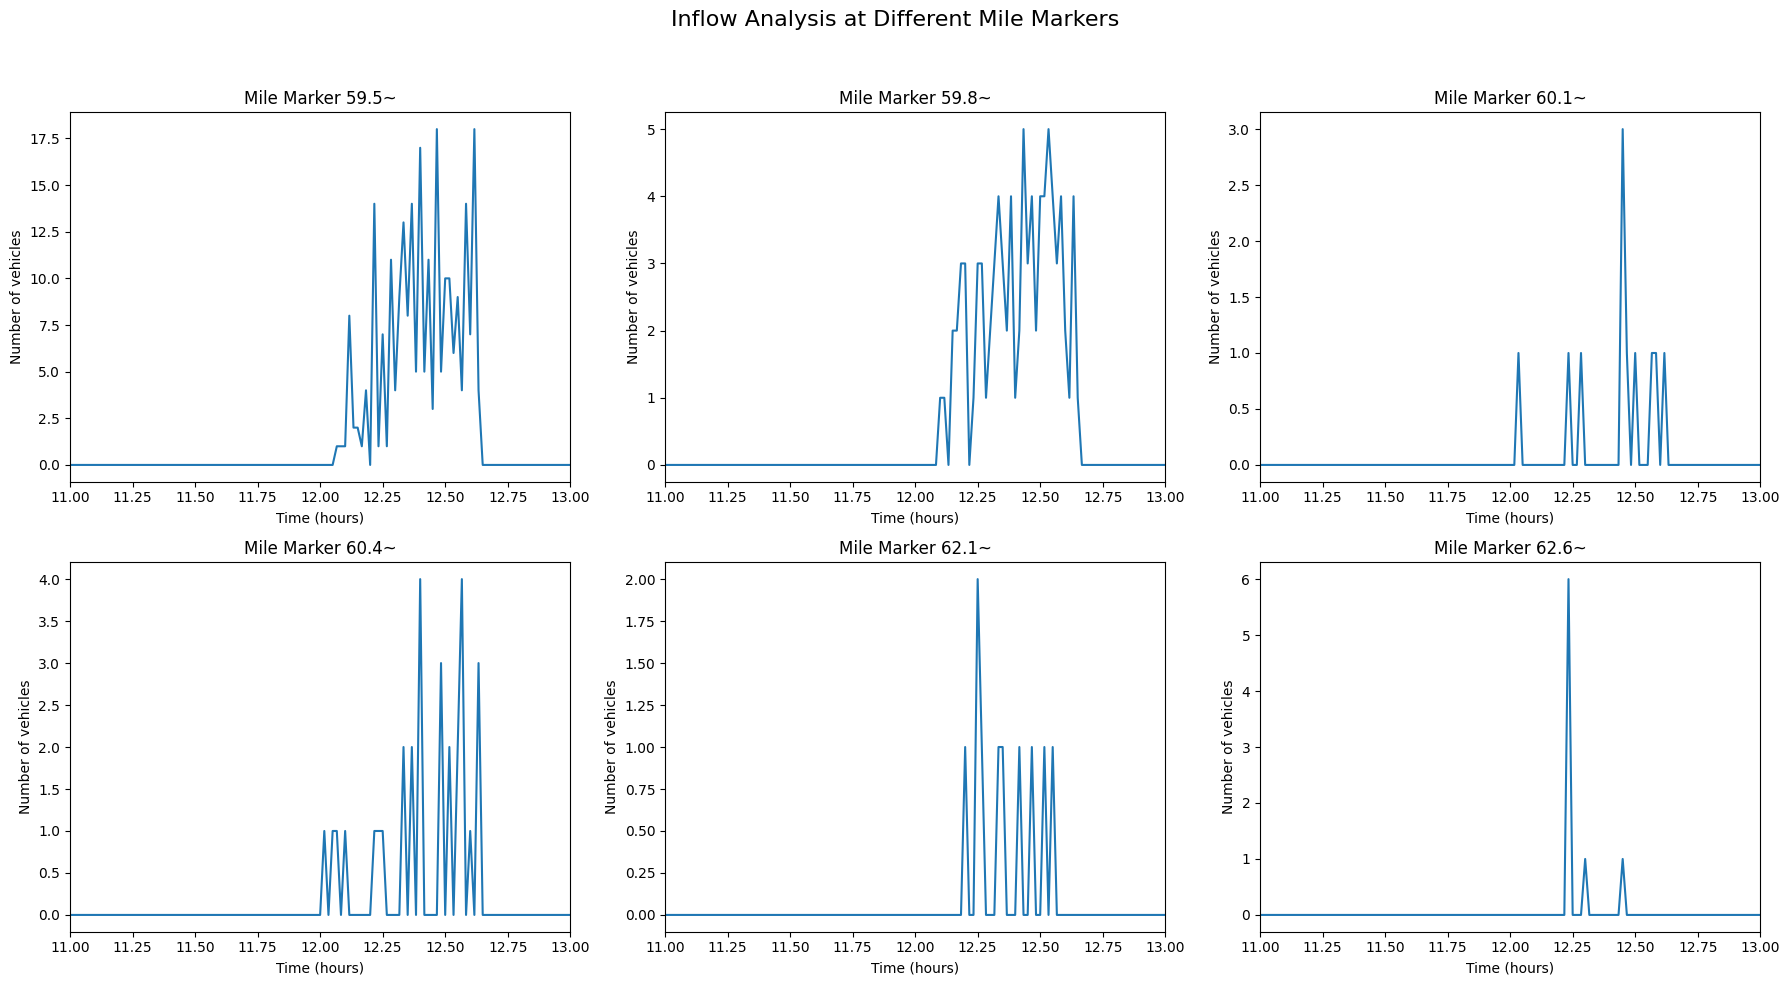

In [23]:
# ##
#calcuate ramp vehicle count at mile marker x
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()


T = 12*3600*25
H = 3600*25
dt = 60*25

loc = ["59.5~" , "59.8~" , "60.1~" , "60.4~" ,"62.1~" , "62.6~"]
xmin = [59.4 , 59.75 , 60.0, 60.35 , 62.1 , 62.6 ]
xmax = [59.7 , 60.0, 60.3 , 60.5 , 62.3 , 62.8]
io = [True, False, False, True , False, True] ## it is a inlet?

### setting for aggregated plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Inflow Analysis at Different Mile Markers', fontsize=16)

axes = axes.flatten()
#####



for j in range(6):  ###6 ramps total
  inflow_count_t = np.zeros((12*3600*25))
  ax = axes[j]

  minx = xmin[j]
  maxx = xmax[j]
  ymax = -0.013
  for i in range(len(data1)):

    timestamps = np.array(data1.iloc[i]['timestamp']).astype(float) - start_time
    timestamps = timestamps*25
    timestamps = timestamps.astype(int)

    positions = np.array(data1.iloc[i]['x_position'])/5280

    y = np.array(data1.iloc[i]['y_position'])/5280

    #index = np.where((positions < 59.7)) #& (positions < 60.1))  ## at 59.7~
    index = np.where((positions < maxx) & (positions > minx ))

    positions = positions[index]
    timestamps = timestamps[index]
    y = y[index]

    if len(positions) == 0:
        # print('no data')
        continue

    if io[j]: ### outlet, final y value smaller than threshold
      if y[0] < ymax : ### inlet, initial  y value smaller than threshold
        inflow_count_t[timestamps[0]] += 1
    elif y[-1] < ymax:
        inflow_count_t[timestamps[0]] += 1


    # first_x = positions[0]
    # first_y = y[0]

    # in_vehicle = (first_x < 59.7)  and (first_y < -0.013) #and (first_x < 59.92)
    # if in_vehicle:
    #     # print('a')
    #     inflow_count_t[timestamps[0]] += 1



  inflow_count_t1s = np.zeros(T//dt)
  for i in range(T//dt):
      inflow_count_t1s[i] = inflow_count_t[i*dt:(i+1)*dt].sum()


  time = np.arange(0, T//dt) / (H//dt) + 7

  ### plot for each individually
  # plt.xlim(11,13)
  # plt.plot(time, inflow_count_t1s)
  # plt.title(f'Inflow at mile marker {loc[j]}')
  # plt.xlabel('Time (hours)')
  # plt.ylabel('Number of vehicles')
  # plt.savefig(f'Inflow at mile marker {loc[j]}.png')
  # plt.show()

  #### plot together
  ax.plot(time, inflow_count_t1s)
  ax.set_xlim(11, 13)
  ax.set_title(f'Mile Marker {loc[j]}')
  ax.set_xlabel('Time (hours)')
  ax.set_ylabel('Number of vehicles')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

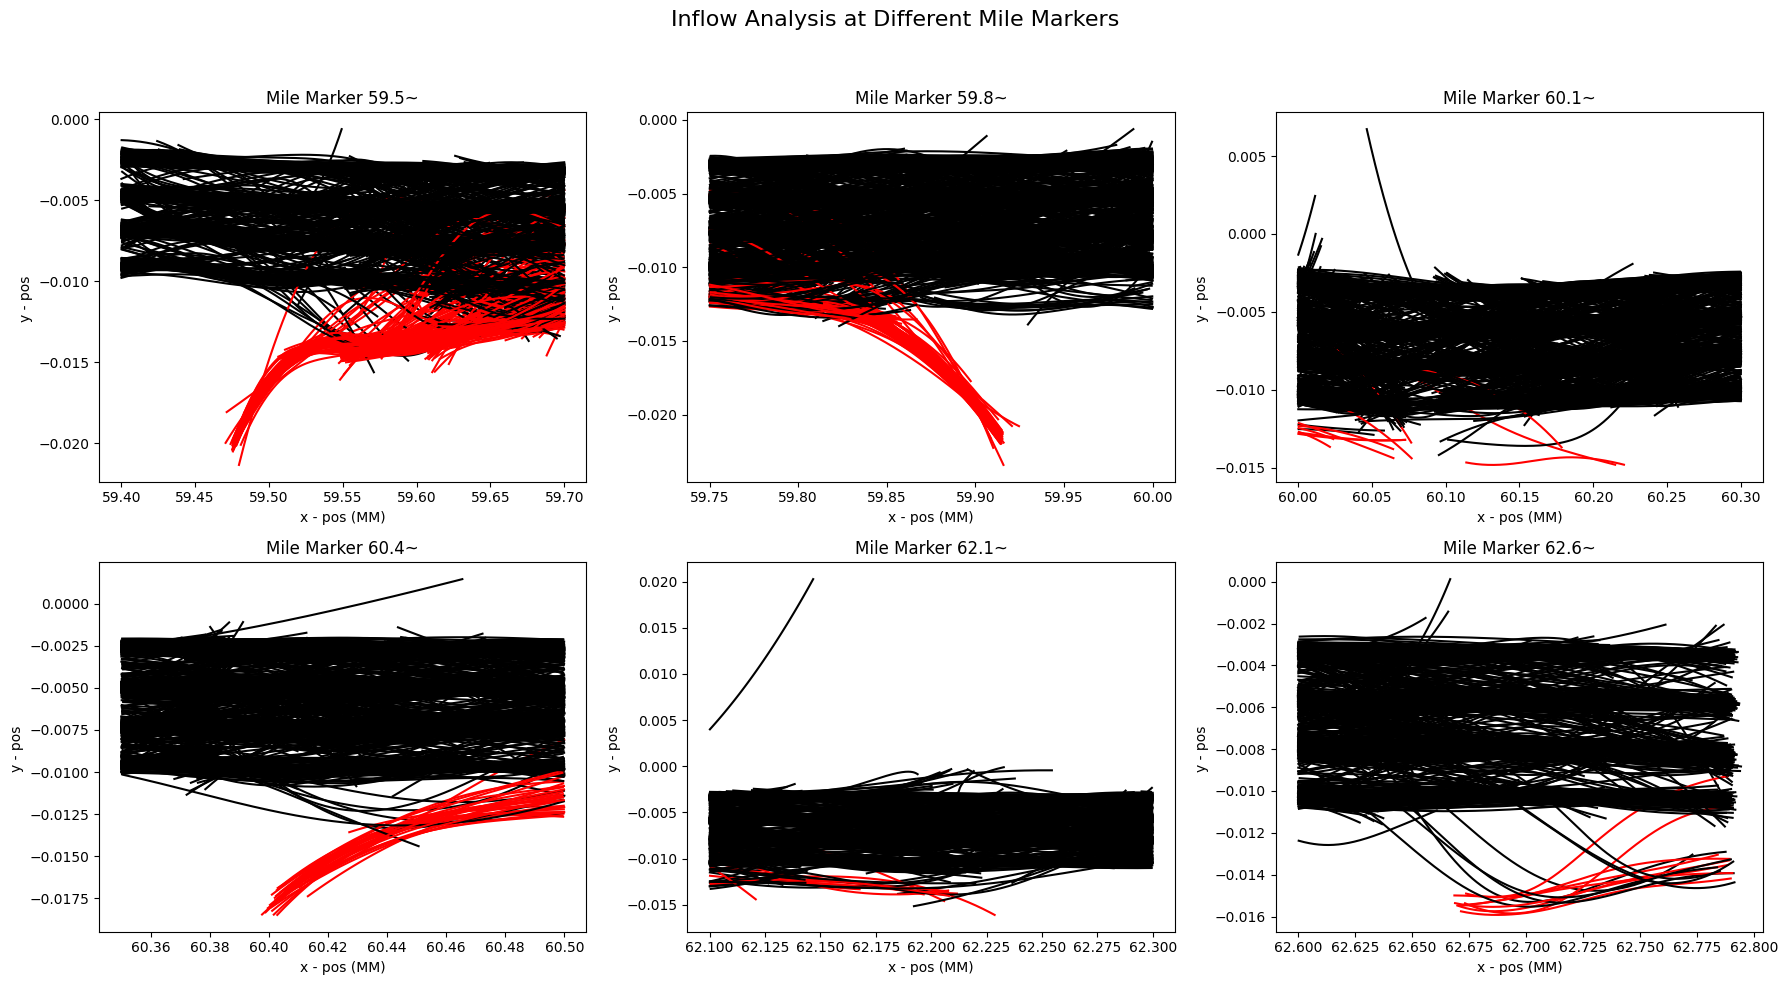

In [21]:
# ##
#calcuate ramp vehicle count at mile marker x
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()


T = 12*3600*25
H = 3600*25
dt = 60*25

loc = ["59.5~" , "59.8~" , "60.1~" , "60.4~" ,"62.1~" , "62.6~"]
xmin = [59.4 , 59.75 , 60.0, 60.35 , 62.1 , 62.6 ]
xmax = [59.7 , 60.0, 60.3 , 60.5 , 62.3 , 62.8]

io = [True, False, False, True , False, True]
### setting for aggregated plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Inflow Analysis at Different Mile Markers', fontsize=16)

axes = axes.flatten()
#####



for j in range(6):  ###6 ramps total
  inflow_count_t = np.zeros((12*3600*25))
  ax = axes[j]

  minx = xmin[j]
  maxx = xmax[j]
  ymax = -0.013
  for i in range(len(data1)):

    timestamps = np.array(data1.iloc[i]['timestamp']).astype(float) - start_time
    timestamps = timestamps*25
    timestamps = timestamps.astype(int)

    positions = np.array(data1.iloc[i]['x_position'])/5280

    y = np.array(data1.iloc[i]['y_position'])

    #index = np.where((positions < 59.7)) #& (positions < 60.1))  ## at 59.7~
    index = np.where((positions < maxx) & (positions > minx )) ###obtain pos index when x withinm ramp

    positions = positions[index]
    timestamps = timestamps[index]
    y = y[index]/5280 ## get all  y pos when x pos within the ramp
    #print(y)
    if len(positions) == 0:
        # print('no data')
        continue
    color = 'black'
    if io[j]: ### outlet, final y value smaller than threshold
      if y[0] < ymax : ### inlet, initial  y value smaller than threshold
      #print(y[3])
        color = 'red'
    elif y[-1] < ymax:
        color = 'red'


    ax.plot(positions, y, color=color)



  ax.set_title(f'Mile Marker {loc[j]}')
  ax.set_xlabel('x - pos (MM)')
  ax.set_ylabel('y - pos ')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

